#### Topic: Clustering and Expectation Maximization
This homework illustrates the use of expectation maximization (EM) methodology for data reduction or clustering.

In [6]:
# importing the dependencies 
import numpy as np
import matplotlib.pyplot as plt
from skimage import io   #this library is used for reading and writing images
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

### EMG Implementation & plots

In [7]:

def EMG(image_path, k):
    image = io.imread(image_path)

    # Below line reshapes the 3D image array into a 2D data array with rows corresponding to pixels and columns corresponding to the RGB values of the pixels. The -1 argument is used to infer the length of the first dimension, and 3 is used for the length of the second dimension. 
    # resulting shape of the new array will be (height * width, channels)
    # The rows of this array will correspond to individual pixels in the image, and the columns will correspond to the color channels of each pixel.
    image_data = np.reshape(image, (-1, 3)) 

    # Below line performs K-Means clustering on the data with number of clusters k and maximum iterations of 3. The fit() method is called to fit the KMeans model to the data, and the resulting KMeans object is stored in the variable kmeans.
    K_means = KMeans(n_clusters=k,n_init=5, max_iter=3).fit(image_data) 

    # here we stored the centroids or we can say mean  of each cluster in a variable m(mean) the dimention of this will be k x n where k is no of clusters and n is no of features which is 3 here and R G B values are stored in each coloumn
    # Basically it is cluster-centers (means) 
    m = K_means.cluster_centers_ 

    # matrix that will store covariance for each cluster of size k x [3 x 3]
    sigma = np.zeros((k, 3, 3)) 

    # here we are calculating covariance matrix for each cluster 
    # here the size of this "np.cov(image_data[K_means.labels_ == i].T)" will be 3 x 3
    for i in range(k):  
        sigma[i] = np.cov(image_data[K_means.labels_ == i].T)

    # yaha basically h me ye store krenge ki kaunse data point ke kitni probability hai kisi cluster se belong krne ki 
    # This line initializes an empty array h with dimensions n x k where n is the number of data points h is used to store the membership probabilities of each data point to each cluster.
    h = np.zeros((image_data.shape[0], k)) 



    # Expected complete log-likelihood is a measure of how well the model is fitting the data. It is the expected value of the complete log-likelihood function, which is the log of the joint probability of the observed data and the model parameters.

    # In the context of the EM algorithm, our  goal is to maximize the expected complete log-likelihood function with respect to the model parameters, which in turn maximizes the likelihood of the observed data.

    # The expected complete log-likelihood is necessary to monitor the progress of the EM algorithm and to determine when to stop the iterations. If the change in the expected complete log-likelihood between iterations is below a certain threshold, the algorithm is assumed to have converged to a local maximum of the likelihood function and is terminated.

    # Below line initializes an empty list Q, which is used to store the expected complete log-likelihood values at each iteration of the EM algorithm.
    Q = list(())


    # this loop will perform EM Steps for maximum number of iterations which are 100
    for i in range(100): 
        # These lines perform the E-step of the EM algorithm. For each cluster j, the probability density function of a multivariate normal distribution with mean m[j] and covariance matrix sigma[j] is calculated for each data point using the multivariate_normal
        # basically below loop calculates the membership probabilities of each data point for all the clusters, which is essential for the expectation step of the EM algorithm.
        for j in range(k): 
            h[:, j] = multivariate_normal.pdf(image_data, mean=m[j], cov=sigma[j]) 
        # After calculating the probability densities for all clusters,I normalized the membership matrix h by dividing it with the sum of probabilities of all clusters. This ensures that each data point's membership probabilities across all the clusters sum up to 1. Thus, h becomes a matrix of size (n_samples, k) where k is the number of clusters. Each row of h represents a data point, and the columns represent the membership probabilities of that point for each cluster.
        h /= np.sum(h, axis=1, keepdims=True) 


        # The log-likelihood values calculated after the E-step are stored in the Q list. The log-likelihood is a measure of how well the model is fitting the data. It is the logarithm of the likelihood function, which is the probability of the observed data given the parameters of the model. The higher the log-likelihood value, the better the model is fitting the data.
        Q.append((i,np.sum(np.log(np.sum(h, axis=1))))) # log-likelyhood values after E-step

        
        # This loop performs the M-step of the EM algorithm. The M-step involves updating the parameters of the model, which in this case are the mean and covariance of each cluster.
        for j in range(k):
            # The mean of each cluster is updated by taking a weighted average of the data points, where the weights are the membership probabilities of the data points for that cluster.
            m[j] = np.average(image_data, axis=0, weights=h[:, j])
            # The covariance matrix of each cluster is updated using the weighted data covariance function, where the weights are the membership probabilities of the data points for that cluster.
            sigma[j] = np.cov(image_data.T, aweights=h[:, j])

        
        # This loop calculates the membership probabilities of each data point for all the clusters using mean and covariance, which is essential for the expectation step of the EM algorithm.
        # Here the membership matrix h is updated again after the parameters have been updated in the M-step
        for j in range(k): 
            h[:, j] = multivariate_normal.pdf(image_data, mean=m[j], cov=sigma[j]) 
        h /= np.sum(h, axis=1, keepdims=True) 
        # The log-likelihood values after the M-step are again stored in the Q list.
        Q.append((i,np.sum(np.log(np.sum(h, axis=1))))) 


        # This block of code checks whether the difference between the log-likelihood values of the current iteration and the two previous iterations is less than a certain threshold (1e-6). If this is the case, it means that the change in the log-likelihood values is insignificant and the algorithm has converged, so the loop is broken and the algorithm stops iterating.
        # the condition np.abs(Q[-1][1] - Q[-3][1]) < 1e-6 is used as a stopping criterion for the EM algorithm. The difference between the log-likelihood values of the current and previous iteration is calculated, and if the absolute difference is less than 1e-6, then the algorithm is terminated.
        # The value 1e-14 is chosen as a threshold because it is a small number and represents a very small difference in log-likelihood values. The choice of this threshold is arbitrary and can be adjusted based on the specific application and the desired level of accuracy. In general, smaller values of the threshold lead to more accurate results but may increase the computational cost.
        if i > 0 and np.abs(Q[-1][1] - Q[-3][1]) < 1e-14: 
            break

    # Here I created a new array of zeros with the same shape and data type as the image_data array, which will be used to store the compressed data.
    compressed_image_Data = np.zeros_like(image_data) 

    # Below assigns the mean value of each cluster to every pixel in the compressed data that belongs to that cluster. It does this by using the cluster labels obtained from the K-means algorithm (K_means.labels_) to index into the compressed_data array and assign the corresponding mean value m[i] to each pixel in that cluster.
    for i in range(k):
        compressed_image_Data[K_means.labels_ == i] = m[i] # mean for each point of every cluster

    # Finally, this line reshapes the compressed_data array to the original shape of the input image image using the reshape() function. The resulting array represents the compressed image, where each pixel value has been replaced with the mean value of the cluster it belongs to.
    compressedImage = np.reshape(compressed_image_Data, image.shape) # compressed image after reshaping

    # These lines display the compressed image using matplotlib's imshow function. The title of the plot indicates the value of k (number of clusters) used in the compression. 
    plt.imshow(compressedImage)
    plt.title('Compressed Image for k={}'.format(k)) 
    plt.axis('off')  #The axis is turned off to remove any ticks and labels.
    plt.show()

    # These lines plot the expected complete log-likelihood (Q) values at each iteration of the EM algorithm. The x-axis represents the iteration number, and the y-axis represents the Q value. The zip(*Q) function is used to unzip the list of tuples into separate lists of x and y values. Then, two lines are plotted: one for the Q values after the E-step (odd iterations) and one for the Q values after the M-step (even iterations). The label parameter in the plot() method is used to create a legend for the two lines. The x and y labels and the title of the plot are also set using the xlabel(), ylabel(), and title() methods. Finally, the plot is displayed using the show() method.

    # The plot shows the convergence of the expected complete log-likelihood (Q) over the iterations of the EM algorithm. The x-axis represents the number of iterations, and the y-axis represents the Q value.The darkyellow line shows the Q values after the E-step, and the other shows the Q values after the M-step. The convergence of Q indicates the convergence of the algorithm towards the optimal solution.If the Q values converge to a certain threshold or stop changing significantly, it suggests that the algorithm has found the optimal solution. The plot helps us to determine whether to stop the algorithm or continue running it for more iterations to obtain a better clustering result.Overall, this plot is a useful tool to monitor the progress of the EM algorithm and assess its convergence.
    
    x,y = zip(*Q)
    plt.plot(x[::2],y[::2], label='Q (Expectation Step)', color='#998c12')
    plt.plot(x[1::2],y[1::2], label='Q (Maximization Step)', color='#086910')
    plt.legend()
    plt.xlabel('No of Iterations')
    plt.ylabel('log-likelihood')
    plt.title(f'Expected complete log-likelihood for k = {k}')
    plt.show()

    return h, m, Q


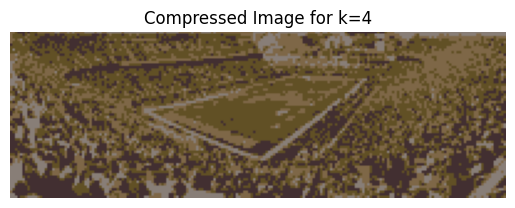

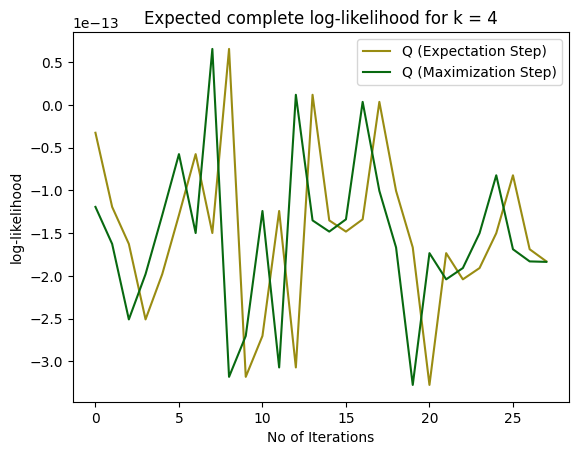

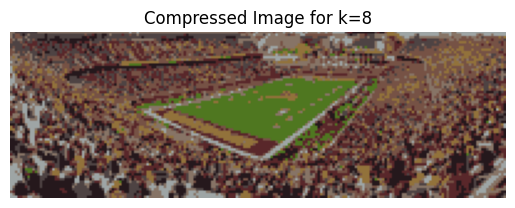

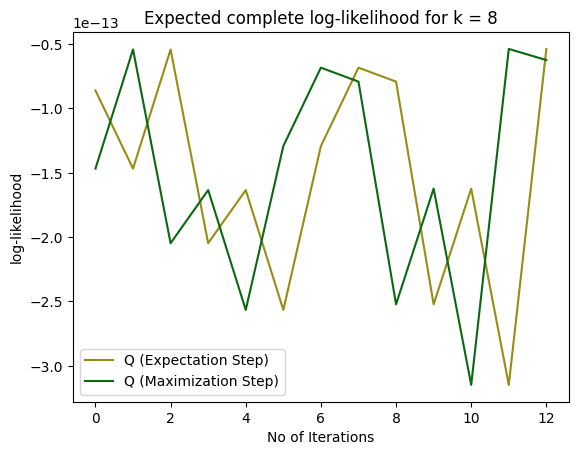

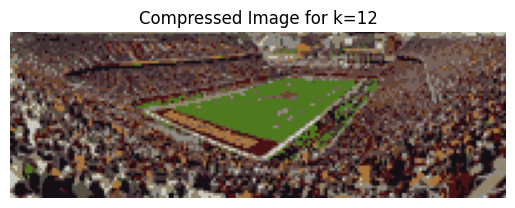

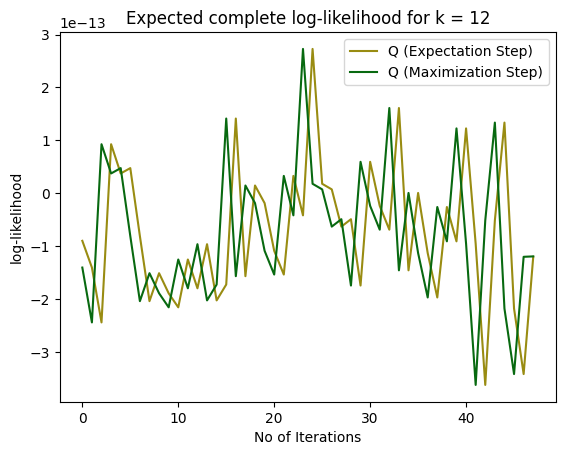

In [8]:
for k in [4,8,12]:
    EMG('stadium.bmp', k) 